In [1]:
#%pip install matplotlib celluloid

# Comparing time and measuring Speed-Up and Efficiency of Parallelisation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from celluloid import Camera
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.2)

class Comparison:
    def __init__(self, bodies = 100, time_steps = [100, 1000, 10000], thread_nums = [1, 2, 4, 8, 10, 12, 16, 32]):
        self.bodies = bodies
        self.time_steps = time_steps
        self.thread_nums = thread_nums

        self.values_iter = []
        self.values_paral = []

        self.readFromFilesIterative()
        self.readFromFilesParallel()

    def readFromFilesIterative(self, **kwargs):
        bodies = self.bodies
        time_steps = self.time_steps

        if 'bodies' in kwargs:
            bodies = kwargs['bodies']

        if 'time_steps' in kwargs:
            time_steps = kwargs['time_steps']

        for i in time_steps:
            f = open('Iterative Ver/results_' + str(bodies) + '/' + str(i) + '_Timesteps', 'r')
            self.values_iter.append(float(f.read()))
            f.close()
    
    def readFromFilesParallel(self, **kwargs):
        bodies = self.bodies
        time_steps = self.time_steps
        thread_nums = self.thread_nums

        if 'bodies' in kwargs:
            bodies = kwargs['bodies']

        if 'time_steps' in kwargs:
            time_steps = kwargs['time_steps']

        if 'thread_nums' in kwargs:
            thread_nums = kwargs['thread_nums']

        for i in time_steps:
            for j in thread_nums:
                f = open('Parallel Ver/results_' + str(bodies) + '/timeSteps_' + str(i) + '/' + str(j) + '_Threads', 'r')
                self.values_paral.append(float(f.read()))
                f.close()

    def printComparison(self):
        subplot_num = len(self.time_steps)
        threads_num = len(self.thread_nums)

        fig, axs = plt.subplots(subplot_num, sharex=True)

        fig.set_figheight(10)
        fig.set_figwidth(20)

        plt.xlabel("The Number Of Threads Used")

        fig.text(0.08, 0.5, "Time(ms)", ha='center', va='center', rotation='vertical')

        if subplot_num != 1:
            for i in range(subplot_num):
                axs[i].plot([self.values_iter[i]] * threads_num)
                axs[i].plot(self.values_paral[i * threads_num : i * threads_num + threads_num])
                axs[i].set_title("Time required for " + str(self.bodies) + " points travelling for " + str(self.time_steps[i]) + " timesteps")
                axs[i].set_xticklabels(['']+self.thread_nums)
        else:
            axs.plot([self.values_iter[0]] * threads_num)
            axs.plot(self.values_paral)
            axs.set_title("Time required for " + str(self.bodies) + " points travelling for " + str(self.time_steps[0]) + " timesteps")
            axs.set_xticklabels(['']+self.thread_nums)

    def printTimeAnalysis(self):
        val_iter = np.array(self.values_iter)
        val_par  = np.array(self.values_paral)
        threads  = np.array(self.thread_nums)
        thr_len = len(threads)

        for i in range(len(self.time_steps)):
            # print(np.divide([val_iter[i]] * thr_len, val_par[i : i + thr_len]))
            # print(np.divide([val_iter[i]] * thr_len, threads * val_par[i: i + thr_len]))

            res = pd.DataFrame({
                "Thread Num" : threads,
                "Speed-Up" : np.divide([val_iter[i]] * thr_len, val_par[i * thr_len : i * thr_len + thr_len]),
                "Efficiency" : np.divide([val_iter[i]] * thr_len, threads * val_par[i * thr_len : i * thr_len + thr_len])
            })

            display(res.style.set_caption(f"S&E of {self.bodies} bodies across {self.time_steps[i]} time steps."))
            

c:\Users\Razmik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Razmik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Razmik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## On 100 Points

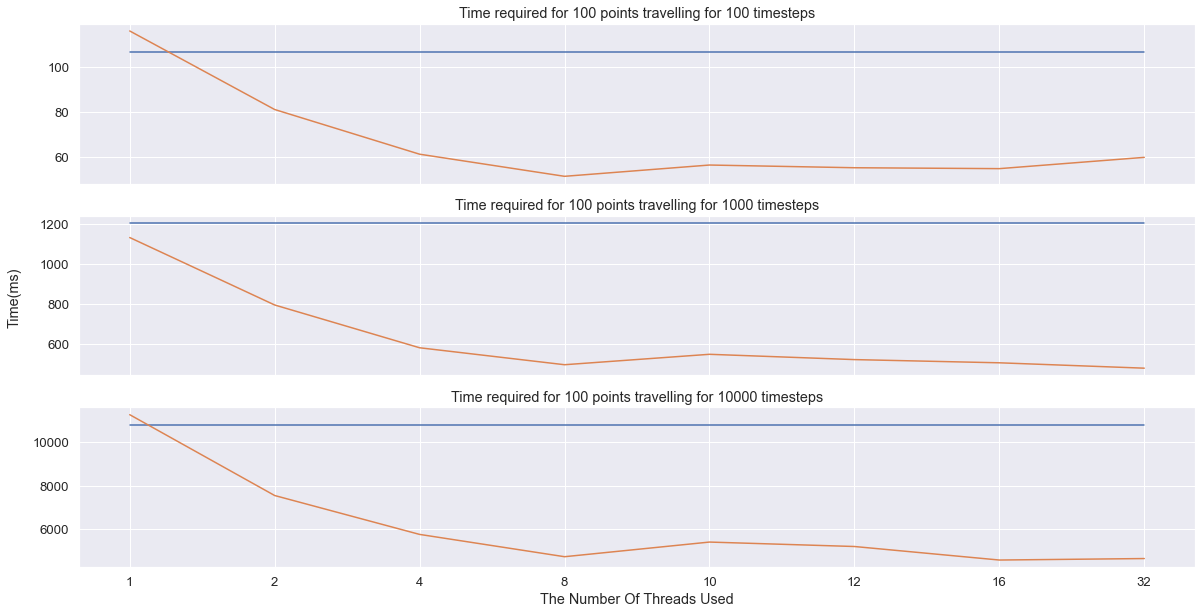

In [3]:
Points100 = Comparison()
Points100.printComparison()

In [4]:
Points100.printTimeAnalysis()

,Thread Num,Speed-Up,Efficiency
0,1,0.918966,0.918966
1,2,1.312808,0.656404
2,4,1.736156,0.434039
3,8,2.065891,0.258236
4,10,1.883392,0.188339
5,12,1.924188,0.160349
6,16,1.938182,0.121136
7,32,1.776667,0.055521


,Thread Num,Speed-Up,Efficiency
0,1,1.064944,1.064944
1,2,1.516251,0.758125
2,4,2.073742,0.518436
3,8,2.427592,0.303449
4,10,2.197152,0.219715
5,12,2.308400,0.192367
6,16,2.381480,0.148843
7,32,2.514835,0.078589


,Thread Num,Speed-Up,Efficiency
0,1,0.957482,0.957482
1,2,1.429298,0.714649
2,4,1.873537,0.468384
3,8,2.279895,0.284987
4,10,1.995636,0.199564
5,12,2.074034,0.172836
6,16,2.355951,0.147247
7,32,2.321387,0.072543


## On 1000 Points

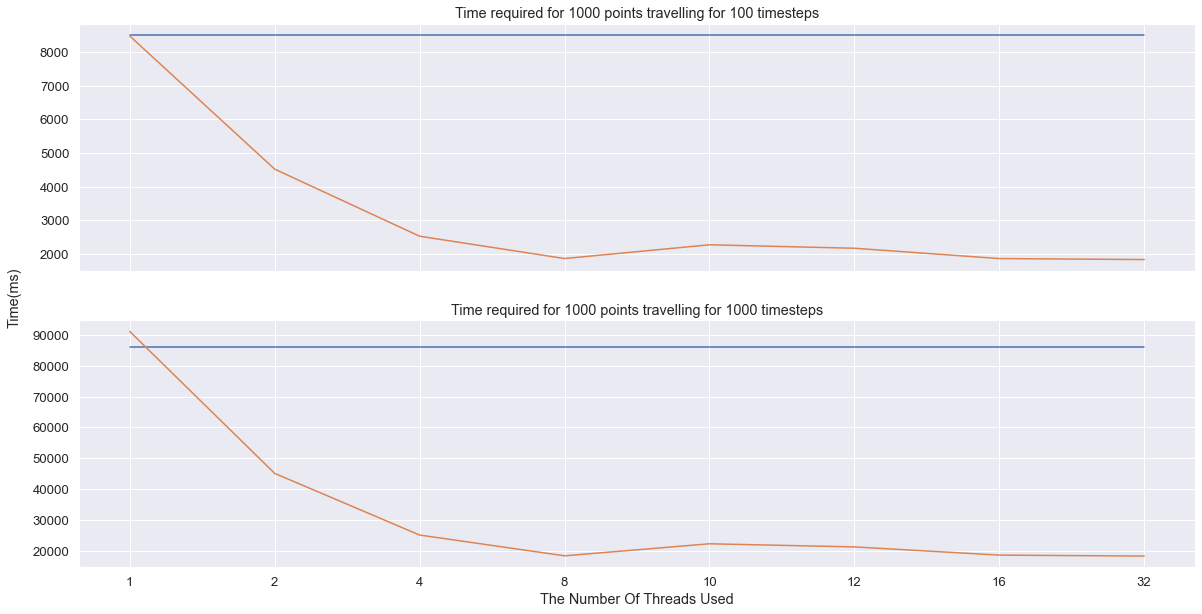

In [5]:
Points1000 = Comparison(bodies=1000, time_steps=[100, 1000])
Points1000.printComparison()

In [6]:
Points1000.printTimeAnalysis()

,Thread Num,Speed-Up,Efficiency
0,1,1.003583,1.003583
1,2,1.883084,0.941542
2,4,3.371802,0.842950
3,8,4.575344,0.571918
4,10,3.750573,0.375057
5,12,3.928117,0.327343
6,16,4.577312,0.286082
7,32,4.650825,0.145338


,Thread Num,Speed-Up,Efficiency
0,1,0.944626,0.944626
1,2,1.902703,0.951351
2,4,3.402389,0.850597
3,8,4.632015,0.579002
4,10,3.829783,0.382978
5,12,4.010590,0.334216
6,16,4.576632,0.286039
7,32,4.652319,0.145385


## On 10000 Points

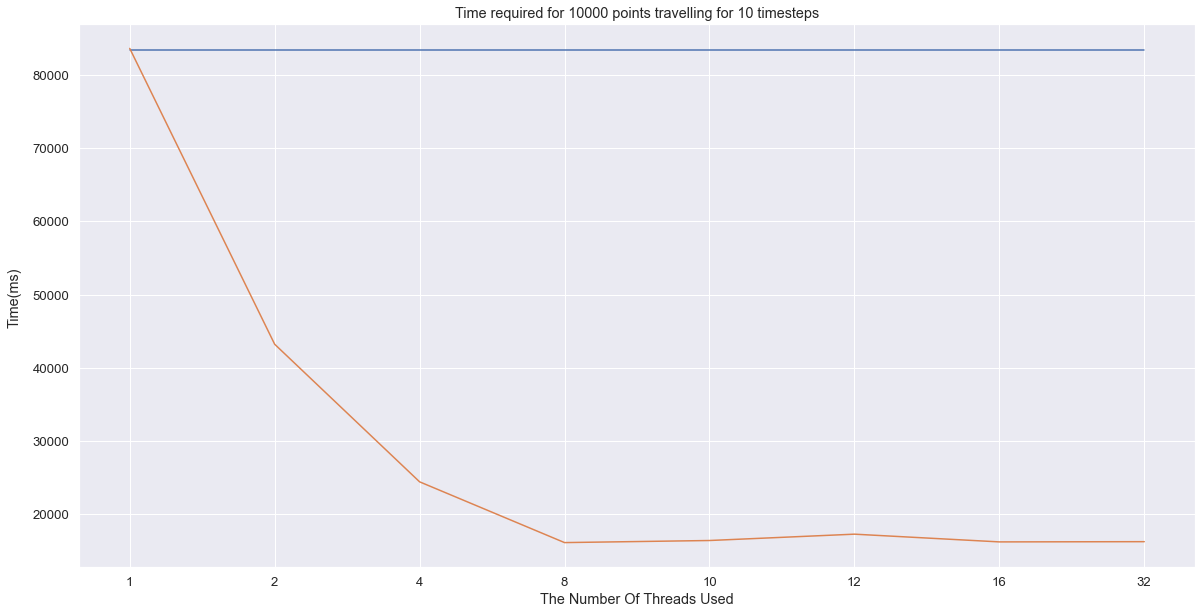

In [7]:
Points10000 = Comparison(bodies=10000, time_steps=[10])
Points10000.printComparison()

In [8]:
Points10000.printTimeAnalysis()

,Thread Num,Speed-Up,Efficiency
0,1,0.997798,0.997798
1,2,1.931713,0.965856
2,4,3.421143,0.855286
3,8,5.187379,0.648422
4,10,5.097097,0.509710
5,12,4.840968,0.403414
6,16,5.157059,0.322316
7,32,5.147073,0.160846


# Visualising the Process

In [9]:
class PointAnimation:
    def __init__(self, input_file, output_file, title, frame_skip = 10):
        self.input_file = input_file
        self.output_file = output_file
        self.frame_skip = frame_skip

        self.fig, self.ax = plt.subplots()
        self.ax.set_title(title)

        self.camera = Camera(self.fig)
        self.timesteps = list()

    def animate(self):
        with open(self.input_file, 'r') as infile:
            data = infile.read().split('\n')

        i = -1
        for line in data[1:]:
            if line.startswith("Body"):
                parts = line.split()
                body_num = int(parts[1])
                x, y, _, _ = map(float, parts[3:])
                if body_num == 1:
                    self.timesteps.append({'x': [], 'y': []})
                    i += 1
                self.timesteps[i]['x'].append(x)
                self.timesteps[i]['y'].append(y)
                

        colors = cm.rainbow(np.linspace(0, 1, len(self.timesteps[0]['x'])))
        frames = i

        for j in range(0, frames, self.frame_skip):
            self.ax.scatter(self.timesteps[j]['x'], self.timesteps[j]['y'], c = colors)
            self.camera.snap()

        animation = self.camera.animate(interval=200)
        animation.save(self.output_file, writer='pillow')

## Animation on Dense and Scattered Point Clouds

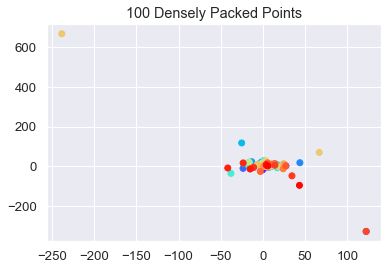

In [10]:
# Using 100 Points in between 0 and 10 moving for 50000 steps. Just Generate them through Input Gen and run through Parallel Ver, put the output into /animations.
animator_dense = PointAnimation("animations/Dense_100_Points", "animations/Dense_animation.gif", "100 Densely Packed Points", 1000)
animator_dense.animate()

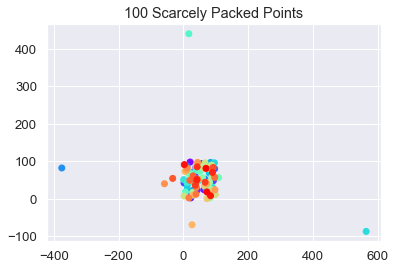

In [11]:
# Using 100 Points in between 0 and 10 moving for 50000 steps. Just Generate them through Input Gen and run through Parallel Ver, put the output into /animations.
animator_dense = PointAnimation("animations/Scattered_100_Points", "animations/Scattered_animation.gif", "100 Scarcely Packed Points", 1000)
animator_dense.animate()

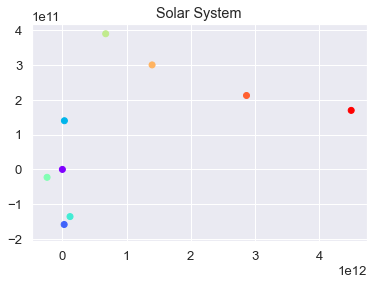

In [12]:
animator_SS = PointAnimation("animations/Solar_System", "animations/SS_animation.gif", "Solar System")
animator_SS.animate()

## Results

![display image alt](animations/Dense_animation.gif) ![display image alt](animations/Scattered_animation.gif) ![display image alt](animations/SS_animation.gif)

# Dirihlet Distribution


Небольшое лирическое отступление.

Изначально для решения задачи был реализован волновой алгоритм. Время волнового алгоритма оказалось значительно хуже итеративного алгоритма.

Дело в том, что волновой алгоритм без каких-либо оптимизаций, хоть и должен замечательно работать теоретически, ужасно работает в реальности.

Происходит по следующей причине.

При обращении к элементу строки массива, в кеш залетает вся строка массива (принцип локальности кеша).
Так, например, обращаясь к первому элементу массива, запоминается вся первая строка.

![display image alt](animations/explanation_1.jpg) 


Оригинальный же волновой подход к решению задачи предполагает обращение к элементам массива по диагонали.
Т.е. процессору придется постоянно перебирать кеш-строки, которые нам будут не нужны уже через одну операцию.

Самый худший случай достигается при достижении диагонали матрицы, где нам придется перебрать N кеш строк.

![display image alt](animations/explanation_2.jpg) 

In [13]:
class DirihletComparison:
    def __init__(self, grids = [100, 300, 500, 1000], thread_nums = [1, 2, 4, 6, 8]):
        self.grids = grids
        self.thread_nums = thread_nums

        self.values_iter = []
        self.values_paral = []

        self.readFromFilesIterative()
        self.readFromFilesParallel()

    def readFromFilesIterative(self, **kwargs):
        grids = self.grids

        if 'grids' in kwargs:
            time_steps = kwargs['grids']

        for i in grids:
            f = open(f'Dirihlet Distribution/parallel_results/{i}_Net_1_Threads', 'r')
            self.values_iter.append(float(f.read()))
            f.close()
    
    def readFromFilesParallel(self, **kwargs):
        grids = self.grids
        thread_nums = self.thread_nums

        if 'grids' in kwargs:
            time_steps = kwargs['grids']

        if 'thread_nums' in kwargs:
            thread_nums = kwargs['thread_nums']

        for i in grids:
            for j in thread_nums:
                f = open(f'Dirihlet Distribution/parallel_results/{i}_Net_{j}_Threads', 'r')
                self.values_paral.append(float(f.read()))
                f.close()

    def printComparison(self):
        subplot_num = len(self.grids)
        threads_num = len(self.thread_nums)

        fig, axs = plt.subplots(subplot_num, sharex=True)

        fig.set_figheight(10)
        fig.set_figwidth(20)

        plt.xlabel("The Number Of Threads Used")

        fig.text(0.08, 0.5, "Time(ms)", ha='center', va='center', rotation='vertical')

        vals = [['']]+[[i, ''] for i in self.thread_nums]
        vals = [item for sublist in vals for item in sublist]

        if subplot_num != 1:
            for i in range(subplot_num):
                axs[i].plot([self.values_iter[i]] * threads_num)
                axs[i].plot(self.values_paral[i * threads_num : i * threads_num + threads_num])
                axs[i].set_title(f"Time required to find approximation of a {self.grids[i]}x{self.grids[i]} Grid")
                axs[i].set_xticklabels(vals)
        else:
            axs.plot([self.values_iter[0]] * threads_num)
            axs.plot(self.values_paral)
            axs.set_title(f"Time required to find approximation of a {self.grids[0]}x{self.grids[0]} Grid")
            axs.set_xticklabels(vals)


    def printTimeAnalysis(self):
        val_iter = np.array(self.values_iter)
        val_par  = np.array(self.values_paral)
        threads  = np.array(self.thread_nums)
        thr_len = len(threads)

        for i in range(len(self.grids)):
            res = pd.DataFrame({
                "Thread Num" : threads,
                "Speed-Up" : np.divide([val_iter[i]] * thr_len, val_par[i * thr_len : i * thr_len + thr_len]),
                "Efficiency" : np.divide([val_iter[i]] * thr_len, threads * val_par[i * thr_len : i * thr_len + thr_len])
            })

            display(res.style.set_caption(f"S&E of finding Dirihlet Distribution in parallel."))
            

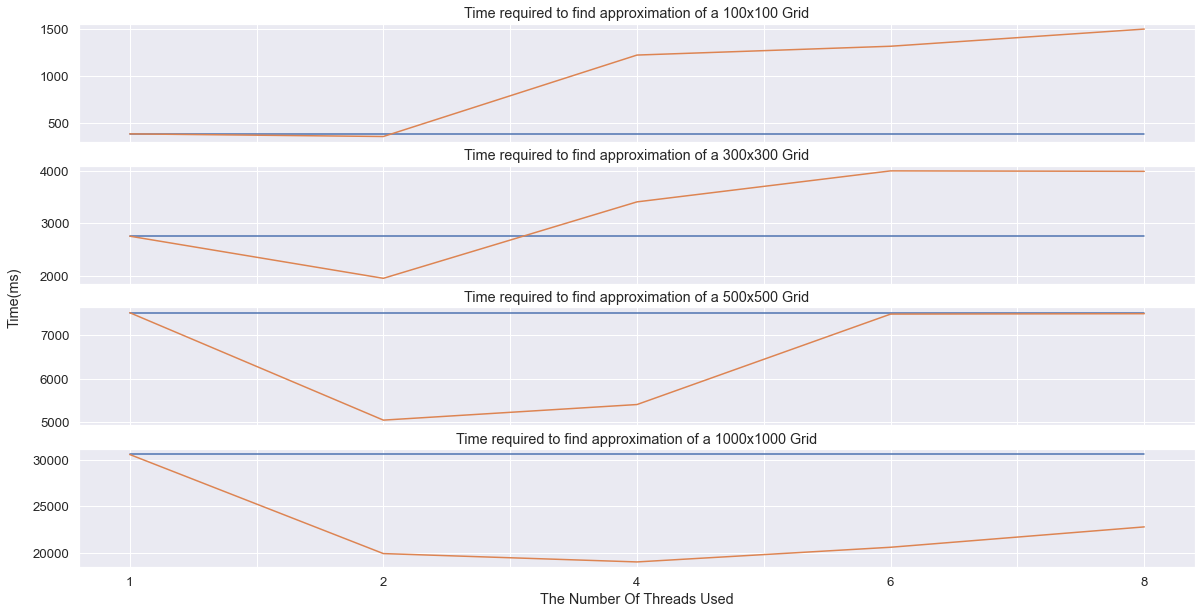

In [14]:
Net100 = DirihletComparison()
Net100.printComparison()

In [15]:
Net100.printTimeAnalysis()

,Thread Num,Speed-Up,Efficiency
0,1,1.000000,1.000000
1,2,1.078431,0.539216
2,4,0.314286,0.078571
3,6,0.291888,0.048648
4,8,0.256325,0.032041


,Thread Num,Speed-Up,Efficiency
0,1,1.000000,1.000000
1,2,1.410440,0.705220
2,4,0.808448,0.202112
3,6,0.689172,0.114862
4,8,0.690727,0.086341


,Thread Num,Speed-Up,Efficiency
0,1,1.000000,1.000000
1,2,1.485844,0.742922
2,4,1.388015,0.347004
3,6,1.004282,0.167380
4,8,1.003074,0.125384


,Thread Num,Speed-Up,Efficiency
0,1,1.000000,1.000000
1,2,1.533373,0.766687
2,4,1.605486,0.401371
3,6,1.482844,0.247141
4,8,1.340735,0.167592
